In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import music21
from music21 import converter, note, chord, stream, tempo, key, pitch, duration, environment
import multiprocessing
from collections import Counter
from tqdm.auto import tqdm
import warnings

# Suppress specific warnings if needed
warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')
# music21 can be verbose with some warnings, suppress if necessary for cleanliness
# warnings.filterwarnings('ignore', module='music21')


pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
sns.set_theme(style="whitegrid")

# music21 environment configuration (if necessary, e.g., for MuseScore path for visualizations)
# This is often needed for.show() calls to render scores, but not strictly for data extraction.
# try:
#     env = environment.UserSettings()
#     # env.getSettingsPath() # to find where the settings file is
#     # env = '/Applications/MuseScore 3.app/Contents/MacOS/mscore' # Example for macOS
#     # env['musicxmlPath'] = '/Applications/MuseScore 3.app/Contents/MacOS/mscore' # Example for macOS
# except music21.environment.EnvironmentException:
#     print("music21 environment settings could not be configured (e.g., MuseScore path). This is usually fine for headless EDA.")

# Define base directory for the dataset
# The user query states: "the maestro unzipped dataset is in data/"
DATA_DIR = Path('../data/')
MAESTRO_METADATA_FILE = DATA_DIR / 'maestro-v3.0.0.csv' # Common version, adjust if different
MIDI_BASE_PATH = DATA_DIR # MIDI files are in subdirectories like data/2004/, data/2006/ etc.

In [2]:
def load_maestro_metadata(file_path: Path) -> pd.DataFrame | None:
    if not file_path.exists():
        print(f"Metadata file not found: {file_path}")
        return None
    try:
        if file_path.suffix == '.csv':
            df = pd.read_csv(file_path)
        elif file_path.suffix == '.json':
            # MAESTRO JSON is typically one JSON object per line, or a list of objects.
            # Adjust if it's a single JSON object with a top-level key.
            df = pd.read_json(file_path, lines=True if 'v1.0.0' in file_path.name else False) # v1.0.0 was lines=True
            if 'v3.0.0.json' in file_path.name: # v3.0.0 json is not line-delimited
                 df = pd.read_json(file_path)

        else:
            print(f"Unsupported metadata file format: {file_path.suffix}")
            return None
        
        # Construct full MIDI path. MIDI files are in subdirectories named by year,
        # e.g., data/2004/MIDI-Unprocessed_SMF_02_R1_2004_01-04_ORIG_MID--AUDIO_02_R1_2004_06_Track06_wav.midi
        # The 'midi_filename' column in maestro-v3.0.0.csv already contains the year prefix.
        df['midi_filepath'] = df['midi_filename'].apply(lambda x: MIDI_BASE_PATH / x)
        
        # Optional: Check file existence early, though this can be slow for large datasets
        # For now, we'll assume paths are correct and handle errors during parsing.
        # df['midi_exists'] = df['midi_filepath'].apply(lambda x: x.exists())
        # num_listed = len(df)
        # num_found = df['midi_exists'].sum()
        # if num_found < num_listed:
        #     print(f"Warning: {num_listed - num_found} MIDI files listed in metadata not found on disk.")
        # df = df[df['midi_exists']].copy() # Filter for existing files to prevent issues

        return df
    except Exception as e:
        print(f"Error loading metadata from {file_path}: {e}")
        return None

maestro_df = load_maestro_metadata(MAESTRO_METADATA_FILE)

if maestro_df is not None:
    print("MAESTRO Metadata Loaded Successfully:")
    print(maestro_df.head())
    print("\nDataFrame Info:")
    maestro_df.info()
    print(f"\nTotal pieces in metadata: {len(maestro_df)}")
    # A quick check for actual file existence for a small sample if needed for debugging
    # sample_exists = maestro_df.head()['midi_filepath'].apply(lambda x: x.exists())
    # print(f"\nExistence check for first 5 MIDI files:\n{sample_exists}")
else:
    print("Failed to load MAESTRO metadata. Some metadata-driven EDA parts will be skipped.")
    # Initialize an empty DataFrame to prevent errors in later cells if they expect maestro_df
    maestro_df = pd.DataFrame(columns=['canonical_composer', 'canonical_title', 'split', 'year', 'midi_filename', 'duration', 'midi_filepath'])

MAESTRO Metadata Loaded Successfully:
   canonical_composer                canonical_title       split  year                                      midi_filename                                     audio_filename    duration                                      midi_filepath
0          Alban Berg                   Sonata Op. 1       train  2018  2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...  2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...  698.661160  ../data/2018/MIDI-Unprocessed_Chamber3_MID--AU...
1          Alban Berg                   Sonata Op. 1       train  2008  2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...  2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...  759.518471  ../data/2008/MIDI-Unprocessed_03_R2_2008_01-03...
2          Alban Berg                   Sonata Op. 1       train  2017  2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...  2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...  464.649433  ../data/2017/MIDI-Unprocessed_066_PIANO066_MID...
3  Alexander Scria

In [3]:
def load_maestro_metadata(file_path: Path) -> pd.DataFrame | None:
    if not file_path.exists():
        print(f"Metadata file not found: {file_path}")
        return None
    try:
        if file_path.suffix == '.csv':
            df = pd.read_csv(file_path)
        elif file_path.suffix == '.json':
            # MAESTRO JSON is typically one JSON object per line, or a list of objects.
            # Adjust if it's a single JSON object with a top-level key.
            df = pd.read_json(file_path, lines=True if 'v1.0.0' in file_path.name else False) # v1.0.0 was lines=True
            if 'v3.0.0.json' in file_path.name: # v3.0.0 json is not line-delimited
                 df = pd.read_json(file_path)

        else:
            print(f"Unsupported metadata file format: {file_path.suffix}")
            return None
        
        # Construct full MIDI path. MIDI files are in subdirectories named by year,
        # e.g., data/2004/MIDI-Unprocessed_SMF_02_R1_2004_01-04_ORIG_MID--AUDIO_02_R1_2004_06_Track06_wav.midi
        # The 'midi_filename' column in maestro-v3.0.0.csv already contains the year prefix.
        df['midi_filepath'] = df['midi_filename'].apply(lambda x: MIDI_BASE_PATH / x)
        
        # Optional: Check file existence early, though this can be slow for large datasets
        # For now, we'll assume paths are correct and handle errors during parsing.
        # df['midi_exists'] = df['midi_filepath'].apply(lambda x: x.exists())
        # num_listed = len(df)
        # num_found = df['midi_exists'].sum()
        # if num_found < num_listed:
        #     print(f"Warning: {num_listed - num_found} MIDI files listed in metadata not found on disk.")
        # df = df[df['midi_exists']].copy() # Filter for existing files to prevent issues

        return df
    except Exception as e:
        print(f"Error loading metadata from {file_path}: {e}")
        return None

maestro_df = load_maestro_metadata(MAESTRO_METADATA_FILE)

if maestro_df is not None:
    print("MAESTRO Metadata Loaded Successfully:")
    print(maestro_df.head())
    print("\nDataFrame Info:")
    maestro_df.info()
    print(f"\nTotal pieces in metadata: {len(maestro_df)}")
    # A quick check for actual file existence for a small sample if needed for debugging
    # sample_exists = maestro_df.head()['midi_filepath'].apply(lambda x: x.exists())
    # print(f"\nExistence check for first 5 MIDI files:\n{sample_exists}")
else:
    print("Failed to load MAESTRO metadata. Some metadata-driven EDA parts will be skipped.")
    # Initialize an empty DataFrame to prevent errors in later cells if they expect maestro_df
    maestro_df = pd.DataFrame(columns=['canonical_composer', 'canonical_title', 'split', 'year', 'midi_filename', 'duration', 'midi_filepath'])

MAESTRO Metadata Loaded Successfully:
   canonical_composer                canonical_title       split  year                                      midi_filename                                     audio_filename    duration                                      midi_filepath
0          Alban Berg                   Sonata Op. 1       train  2018  2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...  2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...  698.661160  ../data/2018/MIDI-Unprocessed_Chamber3_MID--AU...
1          Alban Berg                   Sonata Op. 1       train  2008  2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...  2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...  759.518471  ../data/2008/MIDI-Unprocessed_03_R2_2008_01-03...
2          Alban Berg                   Sonata Op. 1       train  2017  2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...  2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...  464.649433  ../data/2017/MIDI-Unprocessed_066_PIANO066_MID...
3  Alexander Scria

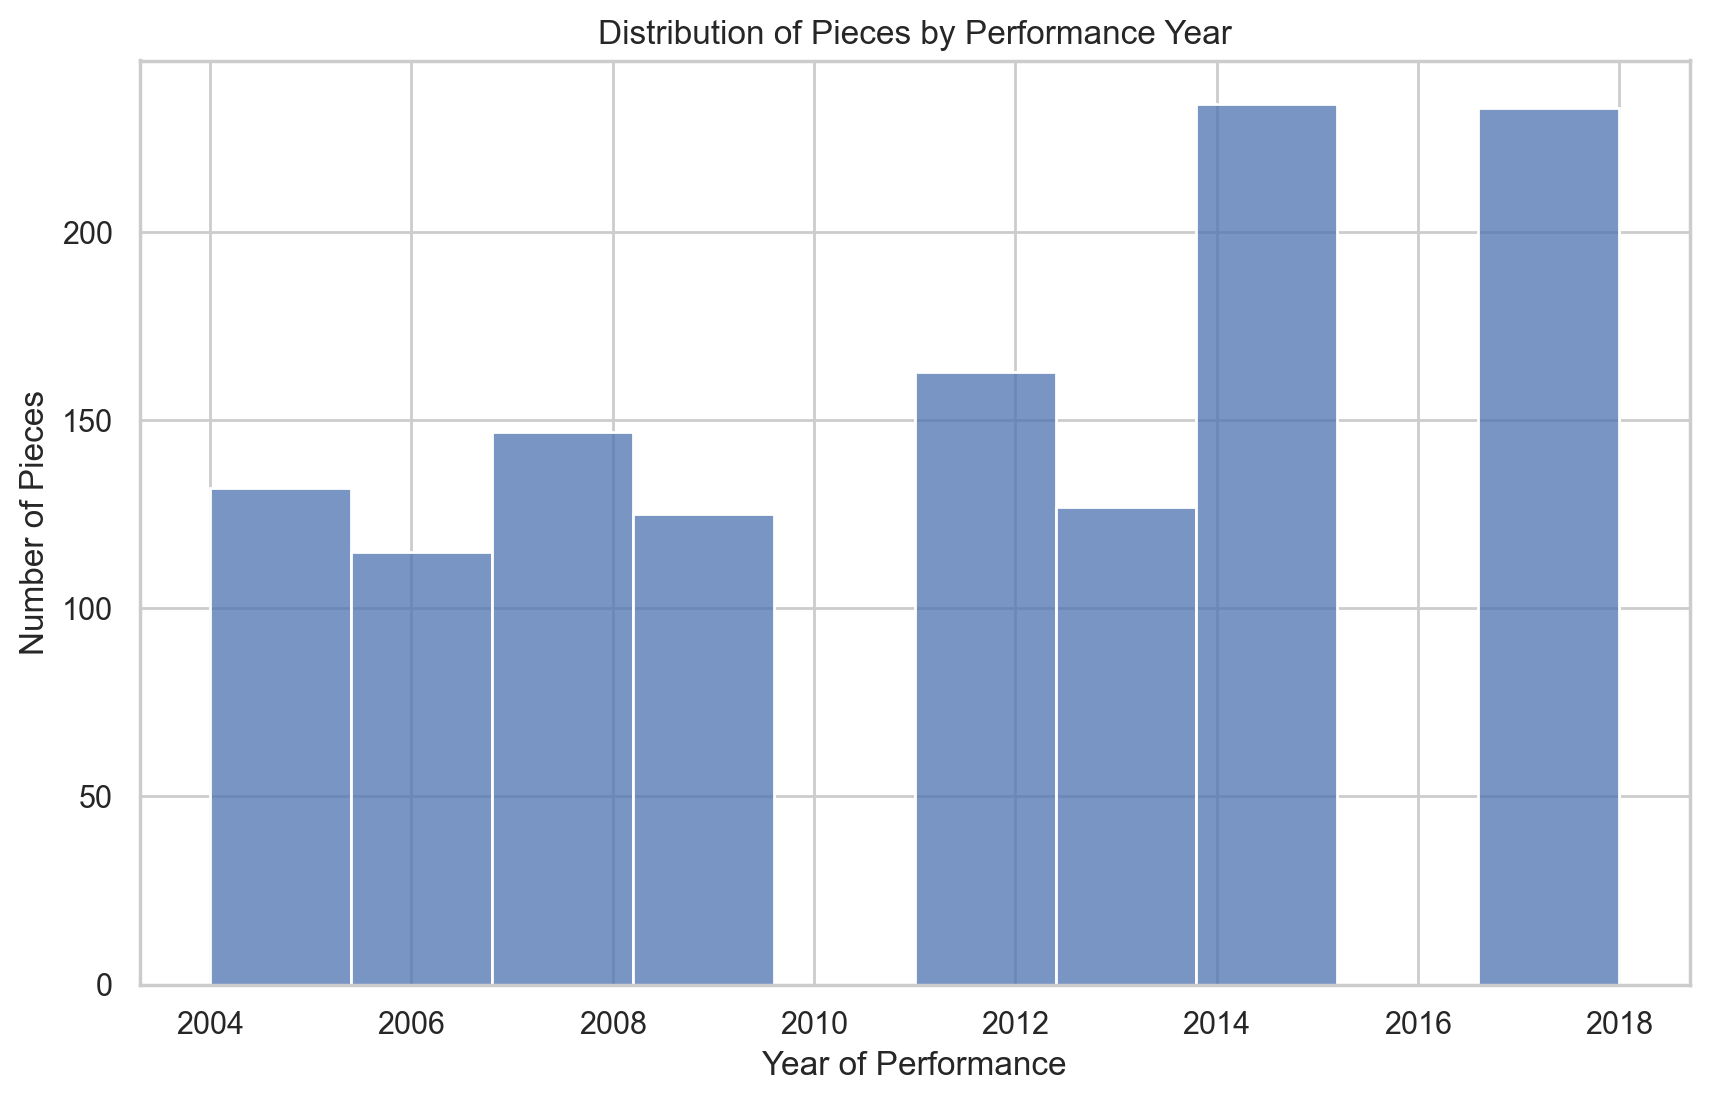

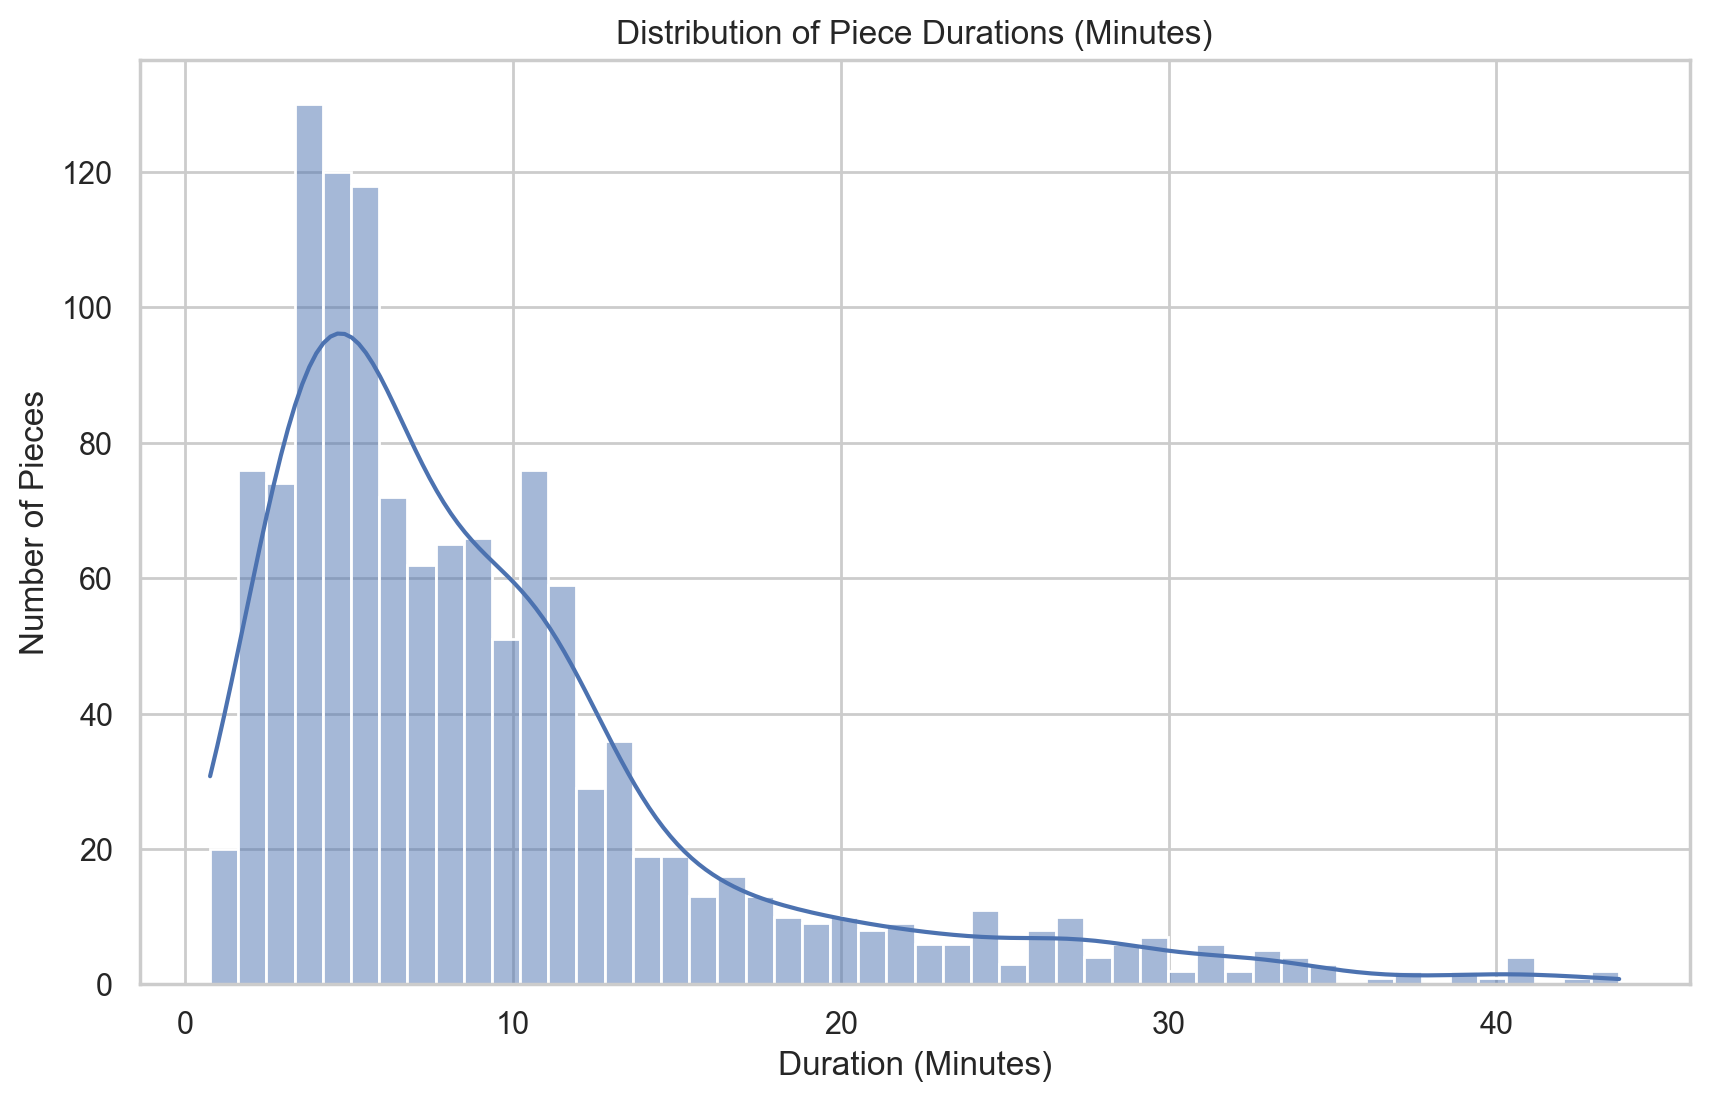

/var/folders/h6/w7dmj13j7w3d94l9lzcsbgr40000gn/T/ipykernel_2997/1415365167.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=composer_counts_to_plot.index, y=composer_counts_to_plot.values, palette="viridis")


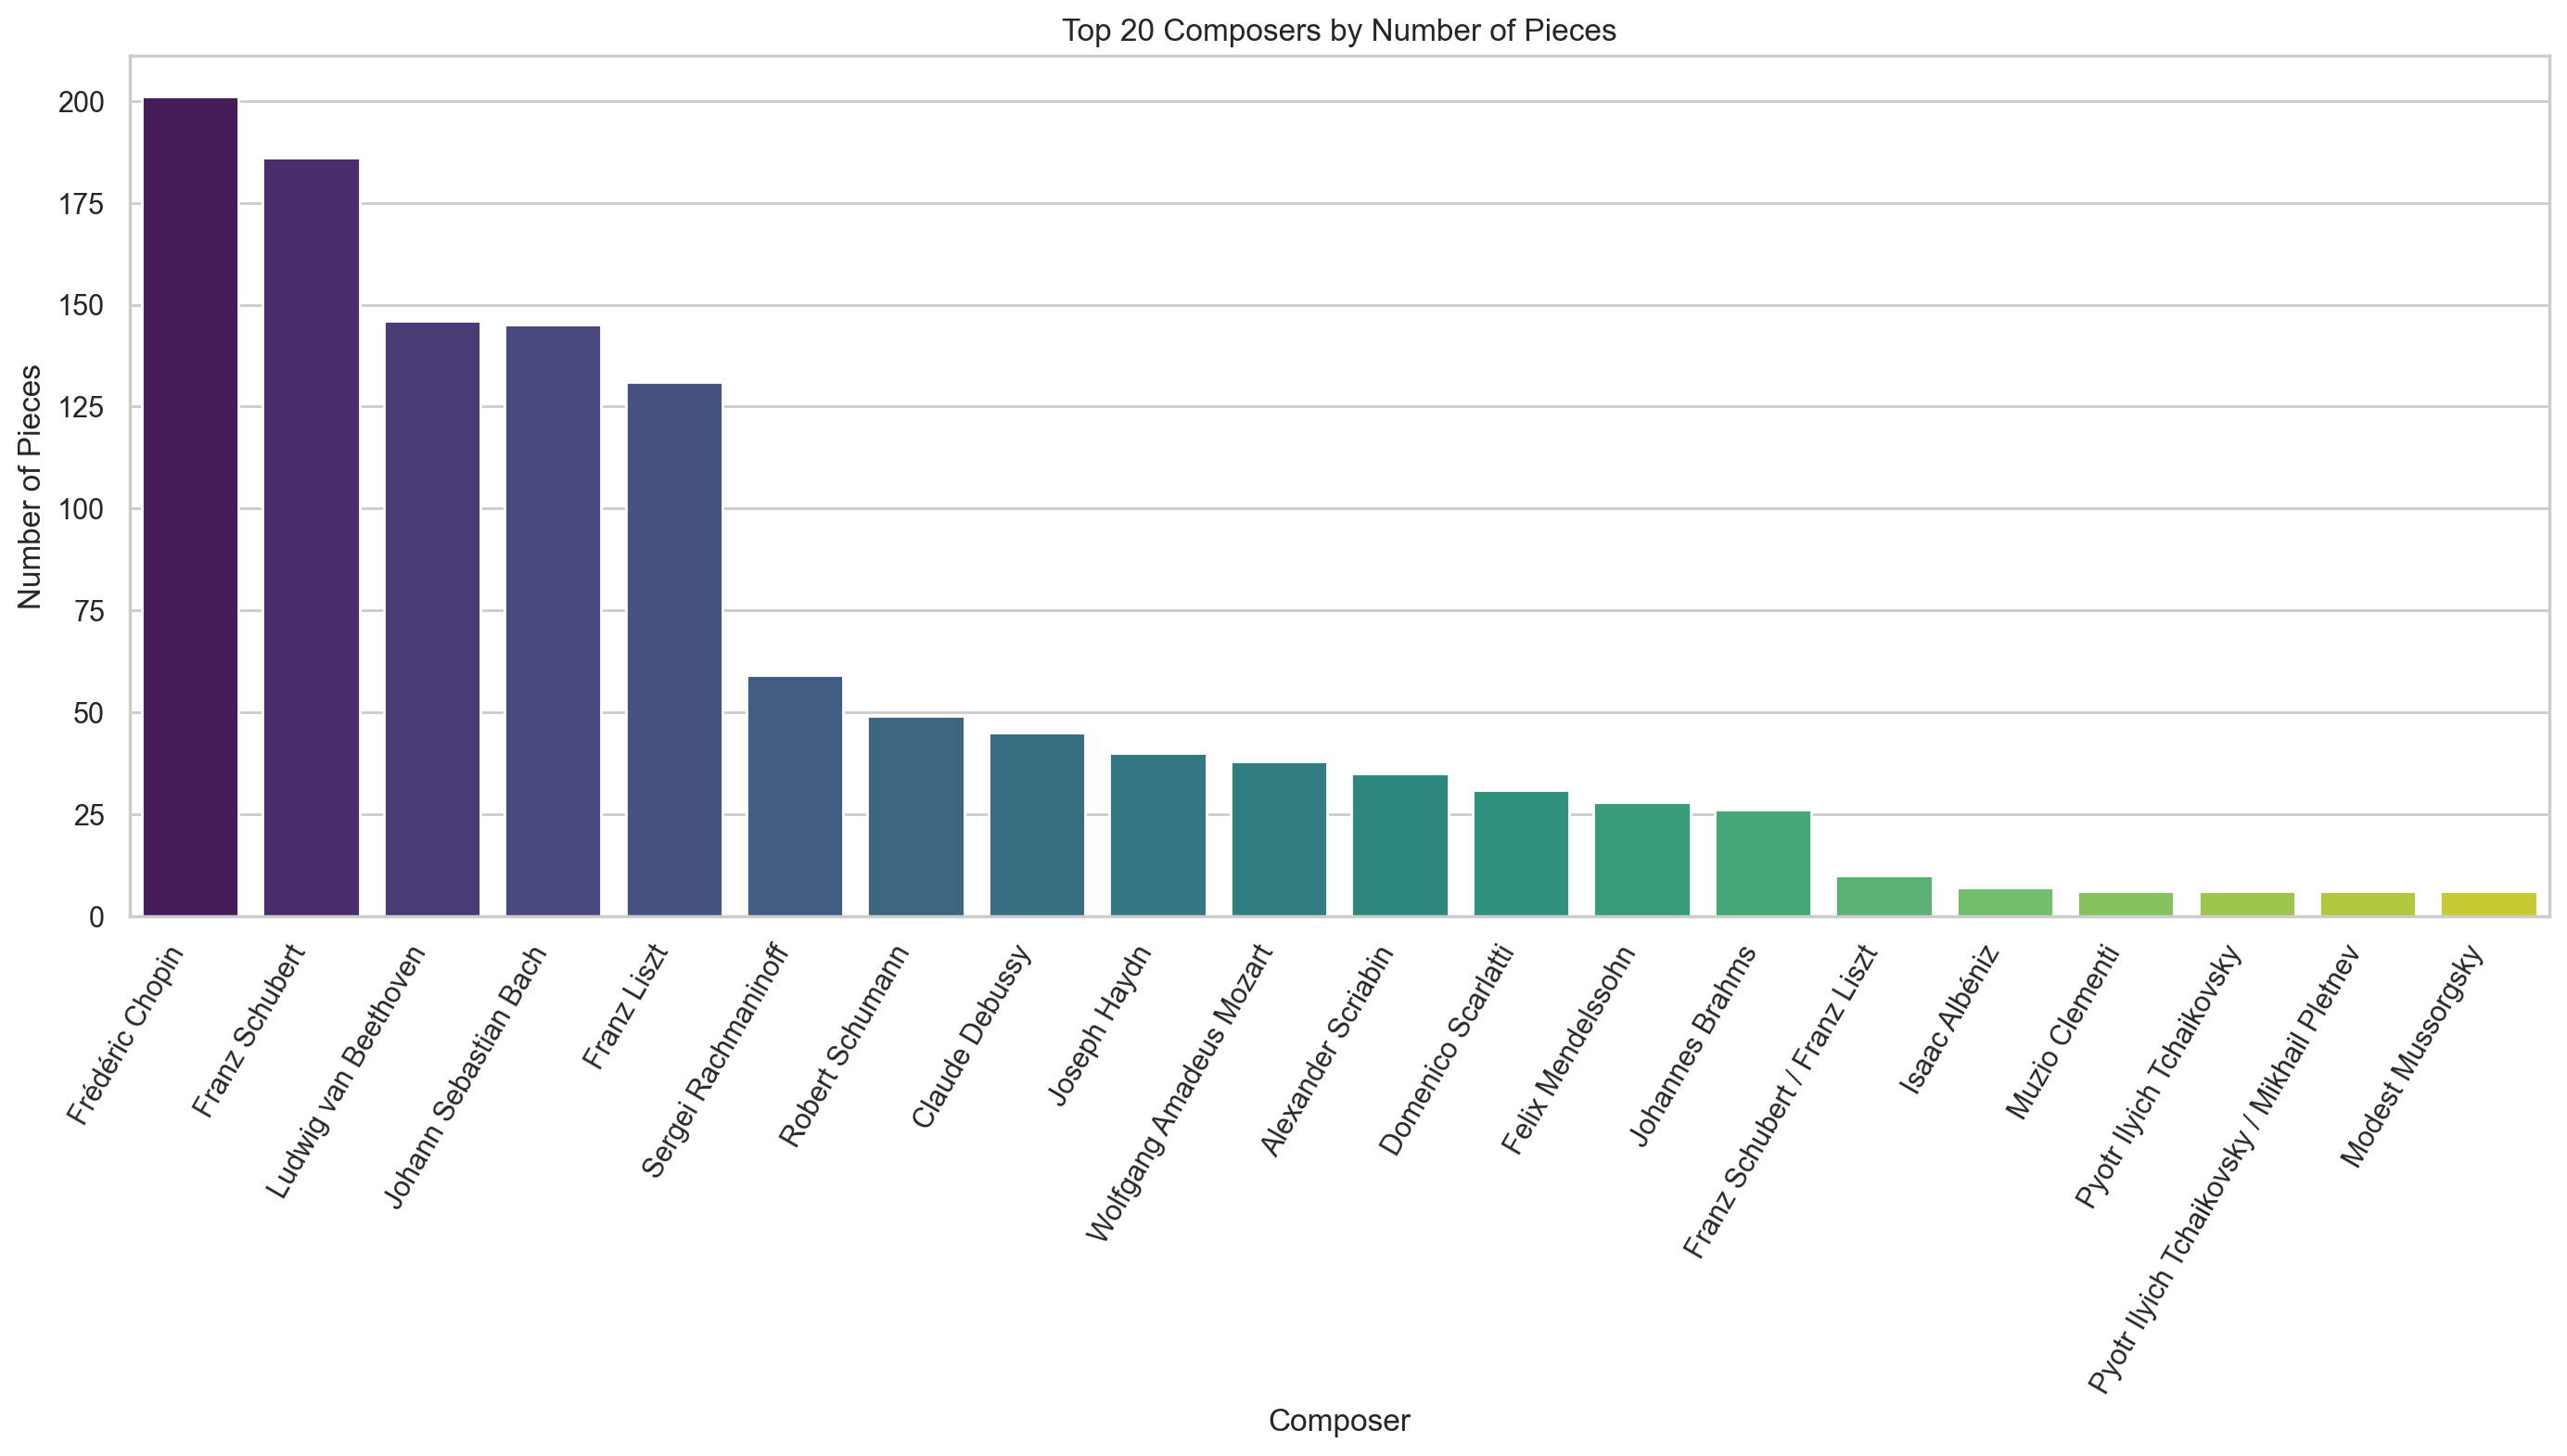


Summary statistics for piece duration (seconds):
count    1276.000000
mean      560.463595
std       443.057431
min        45.155208
25%       261.981576
50%       429.168241
75%       685.018817
max      2624.663508
Name: duration, dtype: float64


In [5]:
if maestro_df is not None and not maestro_df.empty:
    plt.figure(figsize=(10, 6))
    sns.histplot(maestro_df['year'], 
                 bins=len(maestro_df['year'].unique()) if maestro_df['year'].nunique() > 0 else 1, 
                 kde=False)
    plt.title('Distribution of Pieces by Performance Year')
    plt.xlabel('Year of Performance')
    plt.ylabel('Number of Pieces')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.histplot(maestro_df['duration'] / 60, bins=50, kde=True) # Duration in minutes
    plt.title('Distribution of Piece Durations (Minutes)')
    plt.xlabel('Duration (Minutes)')
    plt.ylabel('Number of Pieces')
    plt.show()

    plt.figure(figsize=(14, 8)) # Increased figure size for better label readability
    top_n_composers = 20 # Show more composers
    composer_counts = maestro_df['canonical_composer'].value_counts()
    # Filter out composers with very few pieces for a cleaner plot, e.g., > 5 pieces
    # composer_counts_filtered = composer_counts[composer_counts > 5]
    # composer_counts_to_plot = composer_counts_filtered.nlargest(top_n_composers)
    composer_counts_to_plot = composer_counts.nlargest(top_n_composers)
    
    sns.barplot(x=composer_counts_to_plot.index, y=composer_counts_to_plot.values, palette="viridis")
    plt.title(f'Top {len(composer_counts_to_plot)} Composers by Number of Pieces')
    plt.xlabel('Composer')
    plt.ylabel('Number of Pieces')
    plt.xticks(rotation=60, ha='right') # Adjusted rotation for clarity
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()

    print("\nSummary statistics for piece duration (seconds):")
    print(maestro_df['duration'].describe())
else:
    print("maestro_df is None or empty, skipping metadata visualizations.")

In [13]:
from midi_processing import process_single_midi_file

# use multiprocessing to process all MIDI files in the dataset
with multiprocessing.Pool(processes=2 * multiprocessing.cpu_count()) as pool:
    results = list(tqdm(pool.imap(process_single_midi_file, maestro_df['midi_filepath']), total=len(maestro_df)))

# Convert results to DataFrame
results_df = pd.DataFrame(results)



  0%|          | 0/1276 [00:00<?, ?it/s]

KeyboardInterrupt: 